## Multiple and Polynomial Regression with examples

Originally created by 

**Authors:** Rahul Dave, David Sondak, Will Claybaugh, Pavlos Protopapas

Make sure you have the following packages: jupyterlab scikit-learn pandas matplotlib numpy seaborn . Colab is probably a good place to run this.

## Table of Contents

<ol start="0">
<li> Learning Goals </li>
<li> Polynomial Regression, and  Cab Data</li>
<li> Multiple regression and exploring some Football data </li>
</ol>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from pandas.plotting import scatter_matrix

import seaborn as sns


%matplotlib inline


`sklearn` is focused on the _prediction_ task: given \[new\] data, guess what the response value is. As a result, statsmodels has lots of tools to discuss confidence, but isn't great at dealing with test sets. Sklearn is great at test sets and validations, but can't really discuss uncertainty in the parameters or predictions. In short:

  - sklearn is about putting a line through it and predicting new values using that line. If the line gives good predictions on the test set, who cares about anything else?
  - Another package called statsmodels (not used here) assumes more about how the data were generated, and (if the assumptions are correct) can tell you about uncertainty in the results


### Regression metrics

- **mean squared error**
- **R-squared**: An interpretable summary of how well the model did. 1 is perfect, 0 is a trivial baseline model, negative is worse than the trivial model. Look it up.

  

## Part 1: Polynomial Regression, and the Cab Data

In [2]:
# read in the data, break into train and test
cab_df = pd.read_csv("data/dataset_1.txt")
train_data, test_data = train_test_split(cab_df, test_size=.2, random_state=42)
cab_df.head()

,TimeMin,PickupCount
0,860.0,33.0
1,17.0,75.0
2,486.0,13.0
3,300.0,5.0
4,385.0,10.0


In [3]:
cab_df.shape

(1250, 2)

In [4]:
# do some data cleaning
X_train = train_data['TimeMin'].values.reshape(-1,1)/60
y_train = train_data['PickupCount'].values

X_test = test_data['TimeMin'].values.reshape(-1,1)/60
y_test = test_data['PickupCount'].values


def plot_cabs(cur_model, poly_transformer=None):
    
    # build the x values for the prediction line
    x_vals = np.arange(0,24,.1).reshape(-1,1)
    
    # if needed, build the design matrix
    if poly_transformer:
        design_mat = poly_transformer.fit_transform(x_vals)
    else:
        design_mat = x_vals
    
    # make the prediction at each x value
    prediction = cur_model.predict(design_mat)
    
    # plot the prediction line, and the test data
    plt.plot(x_vals,prediction, '.-', color='k', label="Prediction")
    plt.scatter(X_test, y_test, label="Test Data")

    # label your plots
    plt.ylabel("Number of Taxi Pickups")
    plt.xlabel("Time of Day (Hours Past Midnight)")
    plt.legend()
    plt.show()

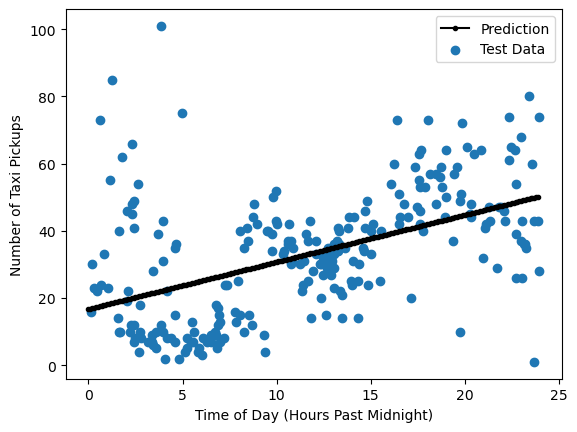

In [5]:
from sklearn.linear_model import LinearRegression
fitted_cab_model0 = LinearRegression().fit(X_train, y_train)
plot_cabs(fitted_cab_model0)

In [7]:
fitted_cab_model0.score(X_test, y_test) # computes R^2 for you

0.240661535615741

We can see that there's still a lot of variation in cab pickups that's not being caught by a linear fit. And the linear fit is predicting massively more pickups at 11:59pm than at 12:00am. However, we can add columns to our design matrix for $TimeMin^2$ and $TimeMin^3$ and so on, allowing a wigglier polynomial that will better fit the data.

We'll be using sklearn's `PolynomialFeatures` to take some of the tedium out of building the new design matrix. In fact, if all we want is a formula like $y \approx \beta_0 + \beta_1 x + \beta_2 x^2 + ...$ it will directly return the new design matrix.

In [8]:
tra = PolynomialFeatures(3, include_bias=True)
xx1 = np.linspace(0,1, 5)
xx2 = np.linspace(9,10, 5)
xx1, xx2

(array([0.  , 0.25, 0.5 , 0.75, 1.  ]),
 array([ 9.  ,  9.25,  9.5 ,  9.75, 10.  ]))

In [9]:
xx3 = np.concatenate([xx1.reshape(-1,1),xx2.reshape(-1,1)], axis = 1)
xx3

array([[ 0.  ,  9.  ],
       [ 0.25,  9.25],
       [ 0.5 ,  9.5 ],
       [ 0.75,  9.75],
       [ 1.  , 10.  ]])

In [10]:
tra = PolynomialFeatures(2, include_bias=False)
tra.fit_transform(xx3)

array([[0.00000e+00, 9.00000e+00, 0.00000e+00, 0.00000e+00, 8.10000e+01],
       [2.50000e-01, 9.25000e+00, 6.25000e-02, 2.31250e+00, 8.55625e+01],
       [5.00000e-01, 9.50000e+00, 2.50000e-01, 4.75000e+00, 9.02500e+01],
       [7.50000e-01, 9.75000e+00, 5.62500e-01, 7.31250e+00, 9.50625e+01],
       [1.00000e+00, 1.00000e+01, 1.00000e+00, 1.00000e+01, 1.00000e+02]])

In [11]:
transformer_3 = PolynomialFeatures(3, include_bias=False)
new_features = transformer_3.fit_transform(X_train)
new_features

array([[6.73333333e+00, 4.53377778e+01, 3.05274370e+02],
       [2.18333333e+00, 4.76694444e+00, 1.04078287e+01],
       [1.41666667e+00, 2.00694444e+00, 2.84317130e+00],
       ...,
       [1.96666667e+01, 3.86777778e+02, 7.60662963e+03],
       [1.17333333e+01, 1.37671111e+02, 1.61534104e+03],
       [1.42000000e+01, 2.01640000e+02, 2.86328800e+03]])

A few notes on `PolynomialFeatures`:

- The interface is a bit strange. `PolynomialFeatures` is a 'transformer' in sklearn. We'll be using several transformers that learn a transformation on the training data and then apply that transformation on future data. On these (more typical) transformers it makes sense to have a `.fit()` and a separate `.transform()`. With PolynomialFeatures, the `.fit()` is pretty trivial, and we often fit and transform in one command, as seen above.
- You rarely want to `include_bias` (a column of all 1s), since sklearn will add it automatically and statsmodels can just `add_constant` right before you fit to the design matrix
- If you want polynomial features for a several different variables, you should call `.fit_transform()` separately on each column and append all the results to the design matrix (unless you also want interaction terms between the newly-created features). See `np.concatenate` for joining arrays.

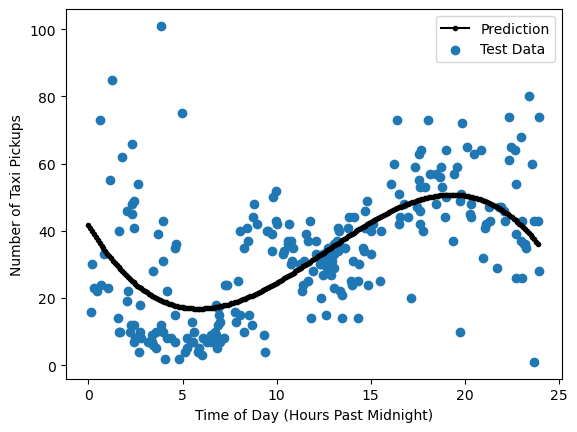

In [12]:
fitted_cab_model3 = LinearRegression().fit(new_features, y_train)
plot_cabs(fitted_cab_model3, transformer_3)

<div class="exercise"><b>Exercise</b></div>

**Questions**:
1. Calculate the polynomial model's $R^2$ performance on the test set. 
2. Does the polynomial model improve on the purely linear model?
3. Make a residual plot for the polynomial model. What does this plot tell us about the model?

*your answer here*
1. See code below
2. Yes, the test set $R^2$ is higher, and the visual fit to both data sets is much better. It even looks like the predicted number of pickups at 11:59 pm and 12:00 am are nearly equal.
3. See the code below. The residuals are much more evenly spread than with the linear model [not shown, but trust us], but they still don't look like an even spread of gaussian noise. This makes it unlikely that the statsmodel assumptions are valid, and we might want to be careful about trusting confidence intervals, etc, and we may want to search for other models entirely.

In [13]:
# your code here
# test r-squared
print("Test R-squared:", fitted_cab_model3.score(transformer_3.fit_transform(X_test), y_test))

Test R-squared: 0.33412512570778785


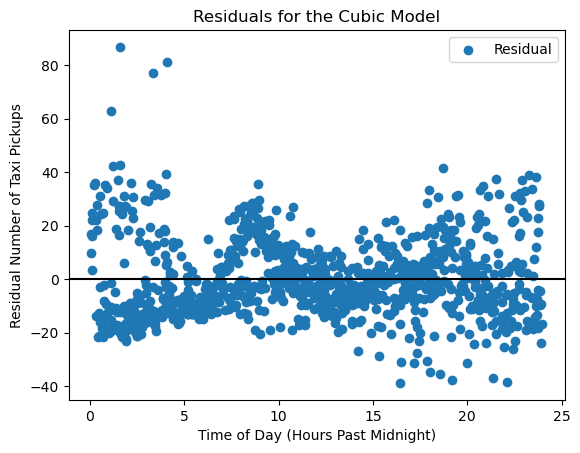

In [14]:
# your code here
design_mat = transformer_3.fit_transform(X_train)

prediction = fitted_cab_model3.predict(design_mat)
residual = y_train - prediction
plt.scatter(X_train, residual, label="Residual")
plt.axhline(0, color='k')

plt.title("Residuals for the Cubic Model")
plt.ylabel("Residual Number of Taxi Pickups")
plt.xlabel("Time of Day (Hours Past Midnight)")
plt.legend()

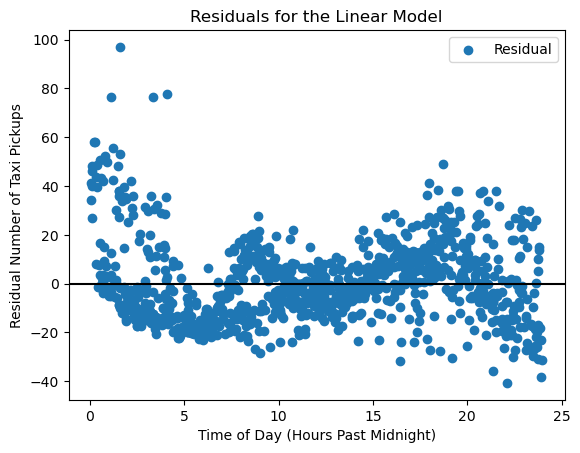

In [15]:
# your code here
design_mat = X_train

prediction = fitted_cab_model0.predict(design_mat)
residual = y_train - prediction
plt.scatter(X_train, residual, label="Residual")
plt.axhline(0, color='k')

plt.title("Residuals for the Linear Model")
plt.ylabel("Residual Number of Taxi Pickups")
plt.xlabel("Time of Day (Hours Past Midnight)")
plt.legend()

#### Other features
Polynomial features are not the only constucted features that help fit the data. Because these data have a 24 hour cycle, we may want to build features that follow such a cycle. For example, $sin(24\frac{x}{2\pi})$, $sin(12\frac{x}{2\pi})$, $sin(8\frac{x}{2\pi})$. Other feature transformations are appropriate to other types of data. For instance certain feature transformations have been developed for geographical data.

## Part 2: Multiple regression and exploring the Football data

Let's move on to a truly interesting dataset. The data imported below were scraped by [Shubham Maurya](https://www.kaggle.com/mauryashubham/linear-regression-to-predict-market-value/data) and record various facts about players in the English Premier League. Our goal will be to fit models that predict the players' market value (what the player could earn when hired by a new team), as estimated by transfermrkt.com.

`name`: Name of the player  
`club`: Club of the player  
`age` : Age of the player  
`position` : The usual position on the pitch  
`position_cat` :  1 for attackers, 2 for midfielders, 3 for defenders, 4 for goalkeepers  
`market_value` : As on transfermrkt.com on July 20th, 2017  
`page_views` : Average daily Wikipedia page views from September 1, 2016 to May 1, 2017  
`fpl_value` : Value in Fantasy Premier League as on July 20th, 2017  
`fpl_sel` : % of FPL players who have selected that player in their team  
`fpl_points` : FPL points accumulated over the previous season  
`region`: 1 for England, 2 for EU, 3 for Americas, 4 for Rest of World  
`nationality`: Player's nationality  
`new_foreign`: Whether a new signing from a different league, for 2017/18 (till 20th July)  
`age_cat`: a categorical version of the Age feature  
`club_id`: a numerical version of the Club feature  
`big_club`: Whether one of the Top 6 clubs  
`new_signing`: Whether a new signing for 2017/18 (till 20th July)  

As always, we first import, verify, split, and explore the data.

## Part 2.1: Import and verification and grouping

In [16]:
league_df = pd.read_csv("data/league_data.txt")
print(league_df.dtypes)
league_df.head()

name             object
club             object
age               int64
position         object
position_cat      int64
market_value    float64
page_views        int64
fpl_value       float64
fpl_sel          object
fpl_points        int64
region          float64
nationality      object
new_foreign       int64
age_cat           int64
club_id           int64
big_club          int64
new_signing       int64
dtype: object


,name,club,age,position,position_cat,market_value,page_views,fpl_value,fpl_sel,fpl_points,region,nationality,new_foreign,age_cat,club_id,big_club,new_signing
0,Alexis Sanchez,Arsenal,28,LW,1,65.0,4329,12.0,17.10%,264,3.0,Chile,0,4,1,1,0
1,Mesut Ozil,Arsenal,28,AM,1,50.0,4395,9.5,5.60%,167,2.0,Germany,0,4,1,1,0
2,Petr Cech,Arsenal,35,GK,4,7.0,1529,5.5,5.90%,134,2.0,Czech Republic,0,6,1,1,0
3,Theo Walcott,Arsenal,28,RW,1,20.0,2393,7.5,1.50%,122,1.0,England,0,4,1,1,0
4,Laurent Koscielny,Arsenal,31,CB,3,22.0,912,6.0,0.70%,121,2.0,France,0,4,1,1,0


In [17]:
league_df.shape

(461, 17)

In [18]:
league_df.describe()

,age,position_cat,market_value,page_views,fpl_value,fpl_points,region,new_foreign,age_cat,club_id,big_club,new_signing
count,461.000000,461.000000,461.000000,461.000000,461.000000,461.000000,460.000000,461.000000,461.000000,461.000000,461.000000,461.000000
mean,26.804772,2.180043,11.012039,763.776573,5.447939,57.314534,1.993478,0.034707,3.206074,10.334056,0.303688,0.145336
std,3.961892,1.000061,12.257403,931.805757,1.346695,53.113811,0.957689,0.183236,1.279795,5.726475,0.460349,0.352822
min,17.000000,1.000000,0.050000,3.000000,4.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,24.000000,1.000000,3.000000,220.000000,4.500000,5.000000,1.000000,0.000000,2.000000,6.000000,0.000000,0.000000
50%,27.000000,2.000000,7.000000,460.000000,5.000000,51.000000,2.000000,0.000000,3.000000,10.000000,0.000000,0.000000
75%,30.000000,3.000000,15.000000,896.000000,5.500000,94.000000,2.000000,0.000000,4.000000,15.000000,1.000000,0.000000
max,38.000000,4.000000,75.000000,7664.000000,12.500000,264.000000,4.000000,1.000000,6.000000,20.000000,1.000000,1.000000


### (Stratified) train/test split
We want to make sure that the training and test data have appropriate representation of each region; it would be bad for the training data to entirely miss a region. This is especially important because some regions are rather rare.

<div class="exercise"><b>Exercise</b></div>

**Questions**:

1. Use the `train_test_split` function to and its 'stratify' argument to split the data, keeping equal representation of each region (This will not work out of the box on this data. Deal with the resulting issue).
2. Deal with the issue you encountered above.
3. How did you deal with the error generated by `train_test_split`? How did you justify your action? 

*your answer here*:
1. See below. We pass the `stratify` argument the data that we want to keep even across train and test sets.
2. See below.
2. Since only one data point has a missing value, we just drop it. +/- one point doesn't seem like it would impact the analysis too much. Of course, someone who knew the premier league might be able to tell which region this player should be in and simply correct the missing value.

In [19]:
# your code here
try:
    # Doesn't work: a value is missing
    train_data, test_data = train_test_split(league_df, test_size = 0.2, 
                                             stratify=league_df['region'])
except:
    # Count the missing lines and drop them
    missing_rows = np.isnan(league_df['region'])
    print("Uh oh, {} lines missing data! Dropping them".format(np.sum(missing_rows)))
    league_df = league_df.dropna(subset=['region'])
    train_data, test_data = train_test_split(league_df, test_size = 0.2, 
                                             stratify=league_df['region'])

Uh oh, 1 lines missing data! Dropping them


In [20]:
train_data.shape, test_data.shape

((368, 17), (92, 17))

Now that we won't be peeking at the test set, let's explore and look for patterns! We'll introduce a number of useful pandas and numpy functions along the way. 

### Groupby
Pandas' `.groupby()` function is a wonderful tool for data analysis. It allows us to analyze each of several subgroups.

Many times, `.groupby()` is combined with `.agg()` to get a summary statistic for each subgroup. For instance: What is the average market value, median page views, and maximum fpl for each player position?

In [21]:
train_data.groupby('position').agg({
    'market_value': np.mean,
    'page_views': np.median,
    'fpl_points': np.max
})

/var/folders/wq/mr3zj9r14dzgjnq9rjx_vqbc0000gn/T/ipykernel_92108/2008482768.py:1: FutureWarning: The provided callable <function mean at 0x103742ac0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  train_data.groupby('position').agg({
/var/folders/wq/mr3zj9r14dzgjnq9rjx_vqbc0000gn/T/ipykernel_92108/2008482768.py:1: FutureWarning: The provided callable <function median at 0x103beeac0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  train_data.groupby('position').agg({
/var/folders/wq/mr3zj9r14dzgjnq9rjx_vqbc0000gn/T/ipykernel_92108/2008482768.py:1: FutureWarning: The provided callable <function max at 0x1037420c0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep c

,market_value,page_views,fpl_points
position,,,
AM,27.283333,1130.0,218
CB,10.165079,355.0,178
CF,13.627551,874.0,224
CM,10.427083,428.5,225
DM,12.870968,478.0,131
GK,7.051389,398.5,143
LB,8.232143,321.0,177
LM,3.714286,304.0,99
LW,12.218333,470.5,224


In [22]:
train_data.position.unique()

array(['CM', 'RW', 'GK', 'CB', 'LB', 'DM', 'CF', 'RB', 'LW', 'LM', 'AM',
       'SS', 'RM'], dtype=object)

In [23]:
train_data.groupby(['big_club', 'position']).agg({
    'market_value': np.mean,
    'page_views': np.mean,
    'fpl_points': np.mean
})

/var/folders/wq/mr3zj9r14dzgjnq9rjx_vqbc0000gn/T/ipykernel_92108/491322342.py:1: FutureWarning: The provided callable <function mean at 0x103742ac0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  train_data.groupby(['big_club', 'position']).agg({
/var/folders/wq/mr3zj9r14dzgjnq9rjx_vqbc0000gn/T/ipykernel_92108/491322342.py:1: FutureWarning: The provided callable <function mean at 0x103742ac0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  train_data.groupby(['big_club', 'position']).agg({


market_value   page_views  fpl_points
big_club position                                       
0        AM           14.906250   603.750000   79.125000
         CB            4.890476   320.071429   42.857143
         CF            8.416667   829.484848   50.151515
         CM            5.426471   320.529412   36.970588
         DM            7.555556   442.111111   41.777778
         GK            4.218750   353.500000   47.000000
         LB            3.441176   192.294118   32.294118
         LM            3.500000   349.500000   40.833333
         LW            5.736842   361.105263   46.315789
         RB            5.065789   295.368421   53.894737
         RM            4.333333   280.333333    1.666667
         RW            8.578947   624.631579   59.789474
         SS            6.700000  2034.600000   26.200000
1        AM           41.428571  2469.857143  156.714286
         CB           20.714286  1004.285714   69.476190
         CF           24.375000  2128.750000   69.687500
         CM           22.571429  1542.571429   80.571429
         DM           20.230769  1260.230769   63.000000
         GK           12.716667   856.583333   72.166667
         LB           15.636364   853.181818   69.090909
         LM            5.000000   936.000000   26.000000
         LW           23.413636  1850.181818   88.181818
         RB           15.642857   905.428571   75.428571
         RM           20.000000  2028.000000   94.000000
         RW           29.600000  1356.000000   62.400000
         SS           38.000000  2196.000000  180.000000

## Part 2.2: Linear regression on the football data

This section focuses on fitting a model to the football data. The model we'll use is


$$
\text{market-value}  = \beta_0 + \beta_1 \text{fpl-points} \\
 + \beta_2\text{age} + \beta_3\text{age}^2 \\
 + \beta_4log_2\left(\text{page-views}\right) + \beta_5\text{new-signing} \\
 + \beta_6\text{big-club} + \beta_7\text{position-cat}
$$

We're including a 2nd degree polynomial in age because we expect pay to increase as a player gains experience, but then decrease as they continue aging. We're taking the log of page views because they have such a large, skewed range and the transformed variable will have fewer outliers that could bias the line. We choose the base of the log to be 2 just to make interpretation cleaner.

<div class="exercise"><b>Exercise</b></div>

**Questions**:

1. Build the $X$ matrix function and fit this model to the training data. How good is the overall model?
2. What should a player do in order to improve their market value? How many page views should a player go get to increase their market value by 10?

In [25]:
# your code here
# building design matrices happens after explore
y_train = train_data['market_value']
y_test = test_data['market_value']

def build_model2_design(df):
    design_mat = df[['fpl_points','age','new_signing','big_club','position_cat']].copy()
    design_mat['log_views'] = np.log2(df['page_views'])
    design_mat['age_squared'] = df['age']**2
    
    #reindex so variables are in a pretty order
    design_mat = design_mat[['fpl_points','age','age_squared','log_views','new_signing','big_club','position_cat']]
    
    
    return design_mat

train_design = build_model2_design(train_data)
test_design = build_model2_design(test_data)

fitted_model_1 = LinearRegression().fit(train_design, y_train)

In [26]:
# your code here
# test set r-squared
r2_score(y_test, fitted_model_1.predict(test_design))

0.6646053413099837

*your answer here*

1. The model is reasonably good. We're capturing about 67% of the variation in market values, and the test set confirms that we're not overfitting too badly.
2. Linear regression on non-experimental data can't determine causation, so we can't prove that a given relationship runs in the direction we might think. For instance, doing whatever it takes to get more page views probably doesn't meaningfully increase market value; it's likely the causation runs in the other direction and great players get more views. Even so, we can use page views to help us tell who is a great player and thus likely to be paid well.

In [31]:
agecoef = fitted_model_1.coef_[1]
age2coef = fitted_model_1.coef_[2]
agecoef, age2coef

(6.327906732613197, -0.12385278618224484)

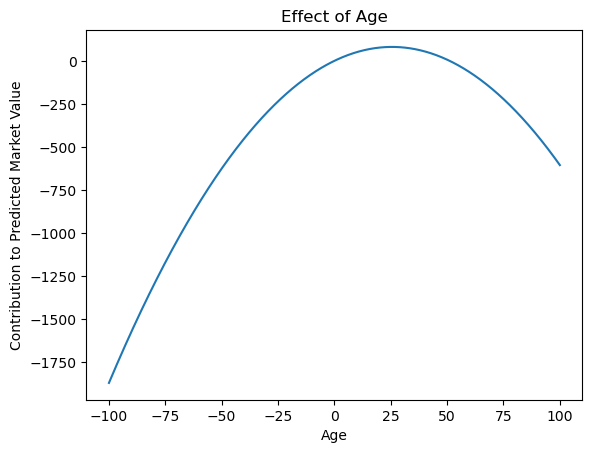

In [32]:
x_vals = np.linspace(-100,100,1000)
y_vals = agecoef*x_vals +age2coef*x_vals**2
plt.plot(x_vals, y_vals)
plt.title("Effect of Age")
plt.xlabel("Age")
plt.ylabel("Contribution to Predicted Market Value")
plt.show()

### Part 2.3: Turning Categorical Variables into multiple binary variables

Of course, we have an error in how we've included player position. Even though the variable is numeric (1,2,3,4) and the model runs without issue, the value we're getting back is garbage. The interpretation, such as it is, is that there is an equal effect of moving from position category 1 to 2, from 2 to 3, and from 3 to 4, and that this effect is about -.61.

In reality, we don't expect moving from one position category to another to be equivalent, nor for a move from category 1 to category 3 to be twice as important as a move from category 1 to category 2. We need to introduce better features to model this variable.

We'll use `pd.get_dummies` to do the work for us.

In [33]:
train_design_recoded = pd.get_dummies(train_design, columns=['position_cat'], drop_first=True)
test_design_recoded = pd.get_dummies(test_design, columns=['position_cat'], drop_first=True)

train_design_recoded.head()

,fpl_points,age,age_squared,log_views,new_signing,big_club,position_cat_2,position_cat_3,position_cat_4
216,149,26,676,10.321928,1,1,True,False,False
435,12,18,324,7.400879,0,0,False,False,False
250,73,34,1156,8.768184,1,1,False,False,True
400,71,32,1024,7.033423,0,0,False,True,False
247,95,31,961,9.306062,0,1,False,True,False


We've removed the original `position_cat` column and created three new ones.

#### Why only three new columns?
Why does pandas give us the option to drop the first category? 

<div class="exercise"><b>Exercise</b></div>

**Questions**:

1. If we're fitting a model without a constant, should we have three dummy columns or four dummy columns?
2. Fit a model and interpret the coefficient of `position_cat_2`.


In [34]:
resu = LinearRegression().fit(train_design_recoded, y_train)

In [35]:
r2_score(y_test, resu.predict(test_design_recoded))

0.6653299562979214

In [36]:
train_design_recoded.shape, y_train.shape

((368, 9), (368,))

**Answers**:
1. If our model does not have a constant, we must include all four dummy variable columns. If we drop one, we're not modeling any effect of being in that category, and effectively assuming the dropped category's effect is 0.
2. Being in position 2 (instead of position 1) has an impact between -1.54 and +2.38 on a player's market value. Since we're using an intercept, the dropped category becomes the baseline and the effect of any dummy variable is the effect of being in that category instead of the baseline category.